In [22]:
#formato binario
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import gspread
from oauth2client.service_account import ServiceAccountCredentials

In [23]:
def obtener_datos():
    # use creds to create a client to interact with the Google Drive API
    scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope)
    client = gspread.authorize(creds)
    # Find a workbook by name and open the first sheet
    # Make sure you use the right name here.
    sheet = client.open("DatosTFG_SistemasRecomendacion").sheet1

    # Extract and print all of the values
    list_of_hashes = sheet.get_all_records()
    #print(list_of_hashes)
    tabla = pd.DataFrame(data=sheet.get_all_records())
    return tabla

In [24]:
def transfor_datos(tabla):
#almacenar en un diccionario de diccionarios cuya clave sea el usuario, y como valor un conjunto de  diccionarios
#(clave=nombre asignatura, valor=ponderacion). No introducimos el Token ni la fecha en la que se realizó el cuestionario. 
    asignaturas= list(tabla.columns)
    diccAsi={}
    diccAsi.setdefault(1,{})
    for k in asignaturas:
        if k != 'Token'and k!='Submitted At':
            for i, j in zip(tabla[k], range(len(tabla['Algoritmia'])) ):
                diccAsi.setdefault(j,{})
                diccAsi[j][k]=i
    tabla1 = pd.DataFrame.from_dict(diccAsi)
    tabla1= tabla1.T
    #transformamos los vacíos en NaN para evitar el error de calcular el coeficiente de correlación de pearson entre un int y un string ('' equivale a un str)
    tabla1= tabla1.replace('', np.nan, regex=True)
    return tabla1

In [25]:
tabla=obtener_datos()
tabla1= transfor_datos(tabla)

In [26]:
#formato binario
def recuperarDatos(nombreArchivo):
    archivo = open(nombreArchivo, "rb")
    tablaDatos = pickle.load(archivo)
    archivo.close()
    return tablaDatos

In [36]:
 
def guardarDatos(nombreArchivo, datos):
    archivo = open(nombreArchivo, "wb")
    pickle.dump(datos, archivo)
    archivo.close()


In [192]:
def checkCostFunction(tabla1, cofi_cost_funct, lamb):
    import numpy as np
    # Create small problem
    X_t = np.random.random((55, 3)) #55
    Theta_t = np.random.random((46, 3)) #46

    # Zap out most entries
    Y = np.dot(X_t,Theta_t.T)
    Y[(np.random.random(np.shape(Y)) > .5)] = 0
    R = np.zeros_like(Y)
    R[Y != 0] = 1

    # Run gradient checking
    X = np.random.random(np.shape(X_t))
    Theta = np.random.random(np.shape(Theta_t))
    n_features = np.size(Theta_t,1)
    
    numgrad = computeNumericalGradient(cofi_cost_funct,np.append(X.flatten(), Theta.flatten()),
                                       Y,R, tabla1,n_features,lamb)    

    J, grad = cofi_cost_funct(np.append(X.flatten(), Theta.flatten()),Y,R,tabla1, n_features,lamb)
    for i in range(grad.shape[0]):
        print((numgrad[i],grad[i]))

In [123]:
def computeNumericalGradient(J,theta,*argv):
    numgrad = np.zeros_like(theta)
    perturb = np.zeros_like(theta)
    e = 1e-4
    
    for p in range(len(theta)):
        # Set perturbation vector
        perturb[p] = e
        (loss1,g) = J(theta - perturb,*argv)
        (loss2,g) = J(theta + perturb,*argv)
        # Compute numerical gradient
        numgrad[p] = (loss2 - loss1)/(2*e)
        perturb[p] = 0
    return numgrad

In [299]:
def cofi_cost_funct(parameters, Y, R, tabla1, n_features, lamb):
    cost =0
    gradient = np.zeros_like(parameters)
    R = np.zeros_like(Y)
    R[Y != 0] = 1
    X= np.reshape(parameters[0: len(tabla1+1) * n_features], (len(tabla1), n_features))
    Theta= np.reshape(parameters[len(tabla1) * n_features : parameters.shape[0]] , (len(tabla1.T),n_features))
    J= (1/2)*sum(sum(np.power((X.dot(Theta.T)- Y ), 2)*R))
    cost=J + ((lamb/2) * sum(sum(np.power(X,2))))+((lamb/2) * sum(sum(np.power(Theta, 2))))
    X_gradient = (((X.dot(Theta.T))- Y) *R).dot(Theta) + X.dot(lamb)               
    Theta_gradient = (((X.dot(Theta.T))-Y) * R).T.dot(X) + Theta.dot(lamb)
    gradient=np.append(X_gradient,Theta_gradient)
    print(cost, gradient)
    return (cost, gradient)

In [300]:
len(tabla1.T)

46

In [301]:
J=0
parameters=[]
parameters=np.append(X.flatten(),Theta.flatten())
J , gradiente=cofi_cost_funct(parameters, Y , R , tabla1, n_features, 0)


71166.7155152 [ 113.42356229  134.91257338  108.20057396 ...,  134.62886104  156.41920674
  168.81712689]


In [302]:
print(J)

71166.7155152


In [222]:
#los resultados obtenidos son muy parecidos, por lo que se valida la función
checkCostFunction(tabla1, cofi_cost_funct,0)

(-3.5198227413957284, -3.5198227411427312)
(-3.2998123455740824, -3.2998123451122234)
(-2.7294508171848975, -2.7294508173837624)
(-5.8757369959039352, -5.8757369959091026)
(-4.8355546803691141, -4.8355546806551839)
(-5.2394314070625114, -5.2394314071576815)
(4.4182899316069779, 4.4182899317504543)
(3.3899844646612109, 3.3899844645222603)
(4.0654458015865202, 4.0654458020137145)
(8.3021999174093253, 8.3021999173315919)
(5.7271557707849752, 5.7271557708508176)
(6.6058048145123394, 6.6058048143433341)
(5.9908615199333326, 5.9908615201300552)
(4.136569154411518, 4.1365691543705001)
(5.249962692914778, 5.2499626931603149)
(1.7675351040224996, 1.7675351039791232)
(1.9416458471255282, 1.9416458467382003)
(1.3204782504772083, 1.3204782499262382)
(4.9624607930809361, 4.9624607933552838)
(4.3880998353529321, 4.3880998357307366)
(2.6111906697678933, 2.6111906700257101)
(4.5586275072651006, 4.5586275067086497)
(4.7616376519954429, 4.7616376516156738)
(3.8727824571083147, 3.8727824571658851)
(-0.68

In [239]:
n_features= Y.shape[1]

Theta= np.random.uniform( low=0, high=1, size= (Y.shape[0], n_features))
X= np.random.uniform( low=0, high=1, size= (Y.shape[1], n_features))
initial_parameters=np.append(X.flatten(), Theta.flatten())

lamb = 1.5

# Define a function to be minimized
def cofiCostFunc_minimize(parameters):
    return cofi_cost_funct(parameters, Y, R, tabla1, n_features, lamb)


# Set the number of iteations
max_iter=20
parameters = (minimize(cofiCostFunc_minimize,initial_parameters,method="CG",jac=True,
                   options={'maxiter':max_iter, "disp":True})).x
yprim=np.dot(X,Theta.T)
print(np.dot(X,Theta.T))

         Current function value: 512.501108
         Iterations: 2
         Function evaluations: 8
         Gradient evaluations: 8
[[ 13.42913862  12.37155963  12.54062248 ...,  12.16538109  12.11642323
   12.24003397]
 [ 11.07521636  10.16985187  10.21798438 ...,  10.65452918  11.0018681
    9.63312098]
 [ 12.65845983  13.16127747  11.68950533 ...,  11.25404227  11.00171254
   13.24031983]
 ..., 
 [ 12.86117695  13.21194202  11.43666364 ...,  11.2943655   10.22122876
   12.34406715]
 [ 12.7561565   11.33680573  11.18439301 ...,  10.61165919  10.44056878
   10.28258414]
 [ 12.19448322  11.22312047  10.62833332 ...,  10.59938313   9.51575672
   10.92450607]]


In [279]:
from pandas import read_table
import operator
u=0
listaF=dict()
tabla2=  tabla1.replace(np.nan, 0, regex=True)
[f]=np.where(tabla2.T[u]==0)
for i in f:
    listaF[i]=yprim[i,u]
    #aquiii
print(f)
#listaF= np.fliplr(np.sort(yprim[f, ]))
listaFOrd = sorted(listaF.items(), key=operator.itemgetter(1))
listaFOrd[:] = listaFOrd[::-1]
listNames= list(tabla1.columns.values)
for i in listaFOrd[0:5]:
    index=i[0]
    print(listNames[index])

[ 7  9 10 12 30 37 41 44]
Desarrollo Avanzado de Sistemas Software
Diseño y Mantenimiento del Software
Diseño e Implementación de Sistemas Digitales
Validación y Pruebas
Sistemas Empotrados y de Tiempo Real


In [267]:
tabla2.T

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
Algoritmia,5.0,4.0,1.0,5.0,5.0,5.0,4.0,4.0,4.0,3.0,...,2.0,3.0,4.0,5.0,5.0,3.0,3.0,5.0,3.0,5.0
Análisis y Diseño de Sistemas,4.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,3.0,2.0,...,4.0,2.0,1.0,2.0,3.0,3.0,3.0,2.0,1.0,4.0
Aplicaciones de Bases de Datos,5.0,5.0,5.0,5.0,5.0,5.0,4.0,1.0,4.0,3.0,...,5.0,4.0,4.0,4.0,5.0,4.0,3.0,5.0,5.0,5.0
Arquitectura de Computadores,5.0,4.0,1.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,...,3.0,2.0,4.0,3.0,4.0,4.0,5.0,4.0,3.0,4.0
Arquitecturas Paralelas,5.0,1.0,1.0,4.0,5.0,4.0,4.0,3.0,4.0,1.0,...,4.0,3.0,3.0,4.0,4.0,5.0,4.0,3.0,4.0,5.0
Bases de Datos,5.0,5.0,4.0,5.0,5.0,4.0,5.0,4.0,5.0,3.0,...,5.0,4.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0
Computación Neuronal y Evolutiva,5.0,3.0,0.0,4.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
Control por Computador,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
Cálculo,5.0,1.0,5.0,4.0,4.0,1.0,3.0,2.0,4.0,3.0,...,2.0,3.0,4.0,3.0,2.0,4.0,3.0,4.0,4.0,1.0
Desarrollo Avanzado de Sistemas Software,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,...,4.0,0.0,4.0,0.0,3.0,0.0,0.0,4.0,4.0,0.0


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

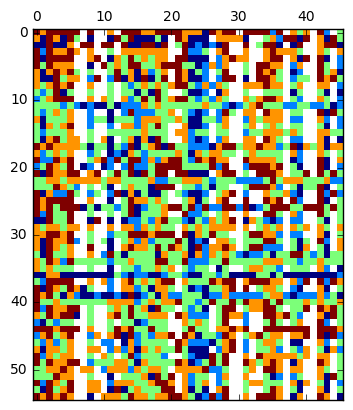

In [247]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.matshow(tabla1)